In [1]:
import os
import re
import glob
import pickle
import datetime
from mordred import Calculator, descriptors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from rdkit import Chem
from rdkit.Chem import Draw
import sys
from rdkit.Contrib.SA_Score import sascorer

# get encoder info in X
import sys
sys.path.append('VAE_model/cpu')
from fast_jtnn import *
from rdkit import Chem

# setting VAE params
model_path = "VAE_model/model.epoch-39"
vocab_path = "VAE_model/model.epoch-39/smi_vocab-2.txt"


# Load vocabulary
vocab = [x.strip("\r\n ") for x in open(vocab_path)]
vocab = Vocab(vocab)

# Initial Step for VAE
vae_model = JTNNVAE(vocab, hidden_size=450, latent_size=32, depthT=3, depthG=20)
vae_model.load_state_dict(torch.load(model_path, map_location='cpu'))
vae_model.cpu()
vae_model.eval()

[08:59:01] WARNING: not removing hydrogen atom without neighbors


JTNNVAE(
  (jtnn): JTNNEncoder(
    (embedding): Embedding(1223, 450)
    (outputNN): Sequential(
      (0): Linear(in_features=900, out_features=450, bias=True)
      (1): ReLU()
    )
    (GRU): GraphGRU(
      (W_z): Linear(in_features=900, out_features=450, bias=True)
      (W_r): Linear(in_features=450, out_features=450, bias=False)
      (U_r): Linear(in_features=450, out_features=450, bias=True)
      (W_h): Linear(in_features=900, out_features=450, bias=True)
    )
  )
  (decoder): JTNNDecoder(
    (embedding): Embedding(1223, 450)
    (W_z): Linear(in_features=900, out_features=450, bias=True)
    (U_r): Linear(in_features=450, out_features=450, bias=False)
    (W_r): Linear(in_features=450, out_features=450, bias=True)
    (W_h): Linear(in_features=900, out_features=450, bias=True)
    (W): Linear(in_features=466, out_features=450, bias=True)
    (U): Linear(in_features=466, out_features=450, bias=True)
    (U_i): Linear(in_features=900, out_features=450, bias=True)
    (W_o)

In [2]:
# read in feature list
from sklearn import base


feature_df = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/ground_truth_model/GT_feature_Mordred.csv')['features']
solvent_mordred = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/solvent_mordred.csv')
base_mordred = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/data/base_mordred.csv')

solvent_columns = list(set(feature_df).intersection(solvent_mordred))
solvent_columns.append('solvent_SMILES')
base_columns = list(set(feature_df).intersection(base_mordred))
base_columns.append('base_SMILES')

solvent_ft = solvent_mordred[solvent_columns]
base_ft = base_mordred[base_columns]

ligand_feature = []
for feature in feature_df:
    if 'ligand_' in feature:
        Mordred = feature.split('ligand_')[1]
        ligand_feature.append(Mordred)
        
feature_list = feature_df.tolist()
print(ligand_feature)
print(feature_list)
print(solvent_ft)
print(base_ft)

['PEOE_VSA10', 'AATS4dv', 'MATS1p', 'AATS6are', 'AATS5v', 'SlogP_VSA1', 'MINsssP', 'AATS6se', 'MATS1Z', 'GATS1are', 'MATS6v', 'MATS5d', 'AATSC5d', 'GATS1se', 'Xch-7d', 'MATS3i', 'MATS1dv', 'AATS5dv', 'AATS2are', 'MATS1m', 'MATS7i', 'GATS4dv', 'SsssP', 'AATS2se', 'MAXsssP', 'AATS1pe', 'GATS1pe', 'ETA_eta_FL', 'ATSC5dv', 'AATS5pe', 'SMR_VSA6', 'BCUTc-1l', 'AATSC1p', 'AXp-1dv', 'BCUTc-1h', 'EState_VSA7', 'AETA_eta_BR', 'AATS5Z', 'ATSC2c', 'AATSC1v']
['ligand_PEOE_VSA10', 'ligand_AATS4dv', 'ligand_MATS1p', 'ligand_AATS6are', 'ligand_AATS5v', 'ligand_SlogP_VSA1', 'ligand_MINsssP', 'ligand_AATS6se', 'ligand_MATS1Z', 'ligand_GATS1are', 'ligand_MATS6v', 'ligand_MATS5d', 'ligand_AATSC5d', 'ligand_GATS1se', 'ligand_Xch-7d', 'concentration', 'ligand_MATS3i', 'temperature', 'ligand_MATS1dv', 'ligand_AATS5dv', 'ligand_AATS2are', 'ligand_MATS1m', 'ligand_MATS7i', 'ligand_GATS4dv', 'ligand_SsssP', 'ligand_AATS2se', 'ligand_MAXsssP', 'ligand_AATS1pe', 'base_GATS1se', 'ligand_GATS1pe', 'ligand_ETA_eta_

### modify input here

In [3]:
#methods = ['ABC', 'GA', 'PSO', 'SA']
methods = ['PSO', 'ABC']
methods = ['PSO/round6', 'PSO/round7', 'PSO/round8', 'PSO/round9']
#methods = ['PSO/round7']
methods = ['PSO/round9']
subfolder = 'c4'

csv_file_paths = []
today = datetime.date.today().strftime("%Y%m%d")



for method in methods:
    print(f"Processing {method} method...")
    folder_path_cn = f'/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/1_Preprocessing_for_Analysis/{method}/{subfolder}'  # 取得當前工作目錄
    folder_list = []

    for item in os.listdir(folder_path_cn):
        if os.path.isdir(os.path.join(folder_path_cn, item)) and item.startswith("Result"):
            folder_list.append(item)

    data = []
    for folder_name in folder_list:
        folder_path = os.path.join(folder_path_cn, folder_name)
        if os.path.exists(folder_path):
            file_list = [file for file in os.listdir(folder_path) if '.sh.o' in file]
            for file in file_list:
                print(f'Processing {file}')
                file_path = os.path.join(folder_path, file)
                with open(file_path, 'r') as f:
                    file_content = f.read()
                parts = file_content.split('\n\n')
                iteration_details, rank_details = parts[-2], parts[-1]
                fitness_list = re.findall('Fitness: ([\de\.\+\-]+)', rank_details)
                fitness_list = list(map(float, fitness_list))
                ranks = rank_details.split("-------------------------")
                #print(ranks)
                
                #read in every data that has rank 1-5
                best = 0
                for i in range(10):
                    #best_fitness_index = fitness_list.index(fitness_list[i])
                    rank_data = ranks[i].split('\n')
                    rank_data = [line.strip() for line in rank_data if line]
                    file_data = {
                        "Folder Name": folder_name,
                        "Ligand_SMILES": rank_data[1].split(": ")[1].strip(),
                        "Fitness": rank_data[2].split(": ")[1].strip(),
                        "temperature": rank_data[5].split(": ")[1].strip(),
                        "concentration": rank_data[6].split(": ")[1].strip(),
                        "base_SMILES": rank_data[7].split(": ")[1].strip(),
                        "solvent_SMILES": rank_data[8].split(": ")[1].strip(),
                        "Reaction_yield": rank_data[10].split(": ")[1].strip()}
                    try:
                        vae_model.encode_latent_mean([file_data['Ligand_SMILES']])
                        calc = Calculator(descriptors, ignore_3D=True)
                        smiles = (file_data['Ligand_SMILES'])
                        mols = Chem.MolFromSmiles(smiles)
                        mordred_data = calc.pandas([mols])
                        mordred_data = mordred_data.dropna(axis='columns')
                        
                        #print(mordred_data)
                        numeric_cols = mordred_data.select_dtypes(exclude='number')
                        mordred_data.drop(numeric_cols, axis=1, inplace=True)
                        #print(mordred_data.shape)
                        columns_exist = all(item in mordred_data.columns for item in ligand_feature)

                        if columns_exist:
                            if best < 1:
                                data.append(file_data)
                                best = 1
                        #else:
                            #print('Mordred encode failed')
                    except:
                        print(f"Error: {file_data['Ligand_SMILES']}", "encode falied")                
                #need to calculate the Mordred descriptors
        else:
            print(f"Folder '{folder_name}' does not exist.")

    df = pd.DataFrame(data)
    df = pd.merge(df, base_ft, on='base_SMILES')
    df = pd.merge(df, solvent_ft, on='solvent_SMILES')
    
    # modred feature calculating
    calc = Calculator(descriptors, ignore_3D=True)
    smiles_list = list(df['Ligand_SMILES'])
    mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
    mordred_df = calc.pandas(mols)
    ligand_ft = mordred_df[ligand_feature]
    ligand_ft = ligand_ft.rename(columns=dict(zip(ligand_ft.columns, [f"ligand_{col}" for col in ligand_ft.columns])))
    df[["yield_pred", "yield_Std"]] = df["Reaction_yield"].str.split(",", expand=True).astype(float)
    
    df = pd.concat([df, ligand_ft], axis=1)

    df['Fitness'] = df['Fitness'].astype(float)
    df = df.sort_values(by='Fitness', ascending=False)

    if len(df)>10:
        #keep the top 10 rows
        df = df.head(10)
    df.to_csv(os.path.join(folder_path_cn, f"{today}aryl_Report.csv"), index=False)
    print(f"CSV file '{today}aryl_Report.csv' has been created.")

    # 找到重复的文件夹名
    duplicates = df[df.duplicated('Ligand_SMILES')]
    print('Duplicate Smiles:',duplicates['Ligand_SMILES'])

Processing PSO/round9 method...
Processing tmp.sh.o3950857


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


Error: c1ccc(PCP(c2ccccc2)c2ccccc2)cc1 encode falied


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


Processing tmp.sh.o3950859


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Processing tmp.sh.o3950860


# Show orcale results

In [ ]:
# from mordred import Calculator, descriptors
from sklearn.ensemble import RandomForestRegressor
# from rdkit.Chem import PandasTools
import pickle

In [ ]:
def aryl_yield_predict(df: pd.DataFrame, 
                        aryl_rfr: RandomForestRegressor, 
                        ):
    
    df_yield = df[feature_list]
    # df_score = df[pvk_score_feature_list]

    # return pvk_rfr.predict(df_size), pvk_rfc.predict(df_score), df[pvk_size_feature_list], df[pvk_score_feature_list]
    return aryl_rfr.predict(df_yield)

In [ ]:
yield_model_path = '/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Ground_Truth_Model/ground_truth_model/Ground_Truth_RandomForrest_Mordred.pkl'

with open(yield_model_path, 'rb') as f:
    rf_regressor = pickle.load(f)

In [ ]:
rf_regressor.feature_names_in_

array(['ligand_PEOE_VSA10', 'ligand_AATS4dv', 'ligand_MATS1p',
       'ligand_AATS6are', 'ligand_AATS5v', 'ligand_SlogP_VSA1',
       'ligand_MINsssP', 'ligand_AATS6se', 'ligand_MATS1Z',
       'ligand_GATS1are', 'ligand_MATS6v', 'ligand_MATS5d',
       'ligand_AATSC5d', 'ligand_GATS1se', 'ligand_Xch-7d',
       'concentration', 'ligand_MATS3i', 'temperature', 'ligand_MATS1dv',
       'ligand_AATS5dv', 'ligand_AATS2are', 'ligand_MATS1m',
       'ligand_MATS7i', 'ligand_GATS4dv', 'ligand_SsssP',
       'ligand_AATS2se', 'ligand_MAXsssP', 'ligand_AATS1pe',
       'base_GATS1se', 'ligand_GATS1pe', 'ligand_ETA_eta_FL',
       'ligand_ATSC5dv', 'ligand_AATS5pe', 'base_GATS2pe', 'base_GATS3m',
       'ligand_SMR_VSA6', 'ligand_BCUTc-1l', 'ligand_AATSC1p',
       'solvent_NsCH3', 'ligand_AXp-1dv', 'ligand_BCUTc-1h',
       'ligand_EState_VSA7', 'solvent_VSA_EState9', 'ligand_AETA_eta_BR',
       'ligand_AATS5Z', 'base_GATS3Z', 'solvent_GATS4se', 'ligand_ATSC2c',
       'solvent_SdssC', 'ligan

In [ ]:
inital_csv = pd.read_csv('/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/0_Create_Surrogate/cycle0_new.csv')
yield_array = inital_csv['yield']
criteria = np.percentile(yield_array, 100)
print(criteria)
yield_array.max(), yield_array.mean() 

29.4


(29.4, 17.812)

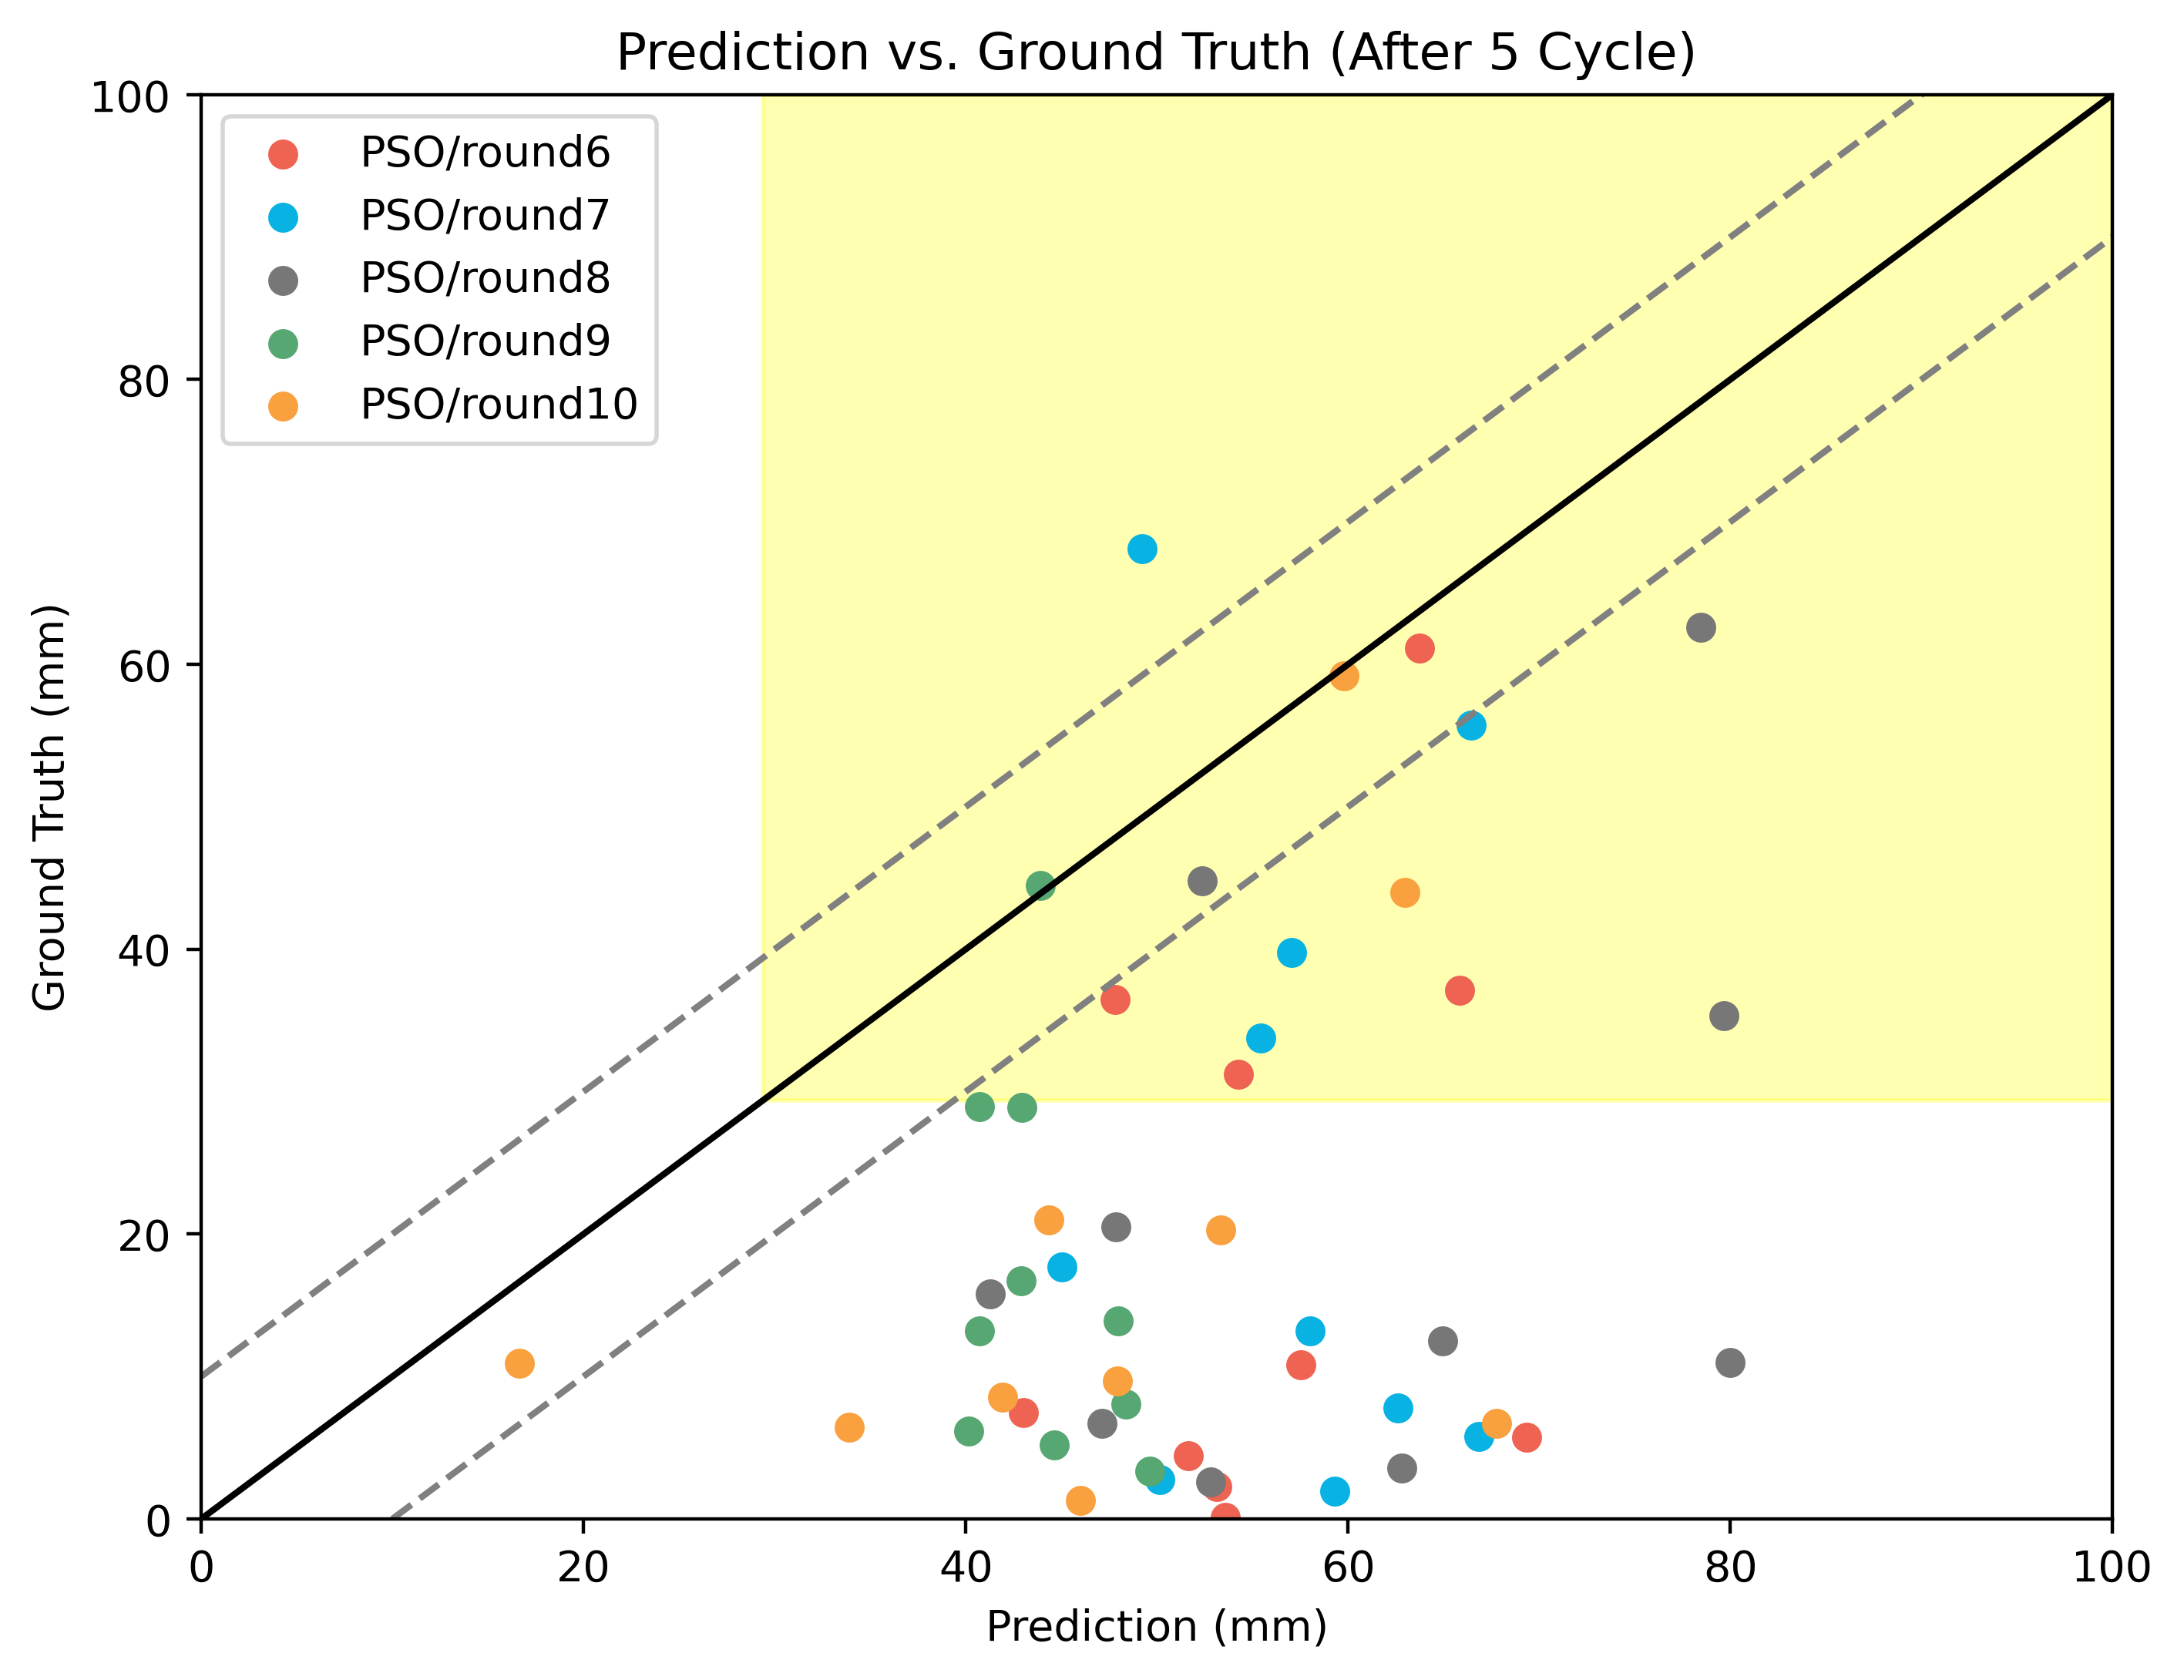

In [ ]:
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
#methods = ['ABC', 'GA', 'PSO', 'SA']
methods = ['PSO', 'ABC']
#methods = ['PSO']
methods = ['PSO/round6', 'PSO/round7', 'PSO/round8', 'PSO/round9','PSO/round10']
#methods = ['PSO/round6', 'PSO/round7', 'PSO/round10']

subfolder = 'c4'
today = datetime.date.today().strftime("%Y%m%d")

folder_path_cn = f'/home/ianlee/opt_ian/Model_Create_and_Results1/Direct_ary/1_Preprocessing_for_Analysis/ABC/{subfolder}'  # 取得當前工作目錄

#methods = ['ABC', 'GA', 'PSO', 'SA']
#methods = ['ABC/10_iter']
colors = ['#EE6352', '#08B2E3', '#777777', '#57A773', '#F9A03F', '#D83367', '#A0A0A0', '#FFB6C1', '#8B4513', '#4682B4']
#colors = ['#EE6352']
domain_max, domain_min = 100.0, 0.0
#domain_max, domain_min = 2.0, 0.0

plt.figure(figsize=(8, 6), dpi=400)
plt.fill_betweenx([criteria, domain_max], criteria, domain_max, color='yellow', alpha=0.3)
for method, color in zip(methods, colors):
    new_folder_path_cn = folder_path_cn.replace('ABC', method)
    file_path = os.path.join(new_folder_path_cn, f'{today}aryl_Report.csv')
    cyclen_pred = pd.read_csv(file_path)
    cyclen_pred = pd.concat((cyclen_pred[feature_list], cyclen_pred['yield_pred']), axis=1)
    yield_features = cyclen_pred.apply(pd.to_numeric, errors='coerce')
    yield_features_nonull = yield_features.dropna()
    # print(cyclen_pred.columns)
    gt_prediction = aryl_yield_predict(yield_features_nonull, rf_regressor)
    
    #save the prediction result to a new csv file

    plt.scatter(yield_features_nonull['yield_pred'], gt_prediction, color=color, label=method)




x = np.linspace(domain_min, domain_max)
plt.plot(x, x, color='black')


plt.xlim(domain_min, domain_max)
plt.ylim(domain_min, domain_max)


plt.plot(x, x + 10, color='gray', linestyle='dashed')
plt.plot(x, x - 10, color='gray', linestyle='dashed')


# plt.text(1.3, 1.8, 'Underestimate', fontsize=12)
# plt.text(1.7, 1.25, 'Overestimate', fontsize=12)
plt.title(f'Prediction vs. Ground Truth (After {int(subfolder[1])+1} Cycle)')
plt.xlabel('Prediction (mm)')
plt.ylabel('Ground Truth (mm)')
plt.legend()
plt.show()